In [11]:
#I just keep this since I need to install it every time.
!pip install -q wfdb

import os
import ast
import wfdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [74]:
#Data Load(just for the features)

PATH_TO_DATA = '/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'ptbxl_database.csv'), index_col='ecg_id')
ECG_df.scp_codes = ECG_df.scp_codes.apply(lambda x: ast.literal_eval(x))
ECG_df.patient_id = ECG_df.patient_id.astype(int)
ECG_df.nurse = ECG_df.nurse.astype('Int64')
ECG_df.site = ECG_df.site.astype('Int64')
ECG_df.validated_by = ECG_df.validated_by.astype('Int64')

SCP = pd.read_csv(os.path.join(PATH_TO_DATA, 'scp_statements.csv'), index_col=0)
SCP = SCP[SCP.diagnostic == 1]

ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709,56.0,1,NaN,63.0,2,0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243,19.0,0,NaN,70.0,2,0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372,37.0,1,NaN,69.0,2,0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014,24.0,0,NaN,82.0,2,0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448,19.0,1,NaN,70.0,2,0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180,67.0,1,NaN,NaN,1,2,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703,93.0,0,NaN,NaN,1,2,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311,59.0,1,NaN,NaN,1,2,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


patient_id                          0
age                                89
sex                                 0
height                          14854
weight                          12408
nurse                            1509
site                               18
device                              0
recording_date                      0
report                              0
scp_codes                           0
heart_axis                       8505
infarction_stadium1             16211
infarction_stadium2             21734
validated_by                     9411
second_opinion                      0
initial_autogenerated_report        0
validated_by_human                  0
baseline_drift                  20230
static_noise                    18575
burst_noise                     21224
electrodes_problems             21807
extra_beats                     19883
pacemaker                       21544
strat_fold                          0
filename_lr                         0
filename_hr 

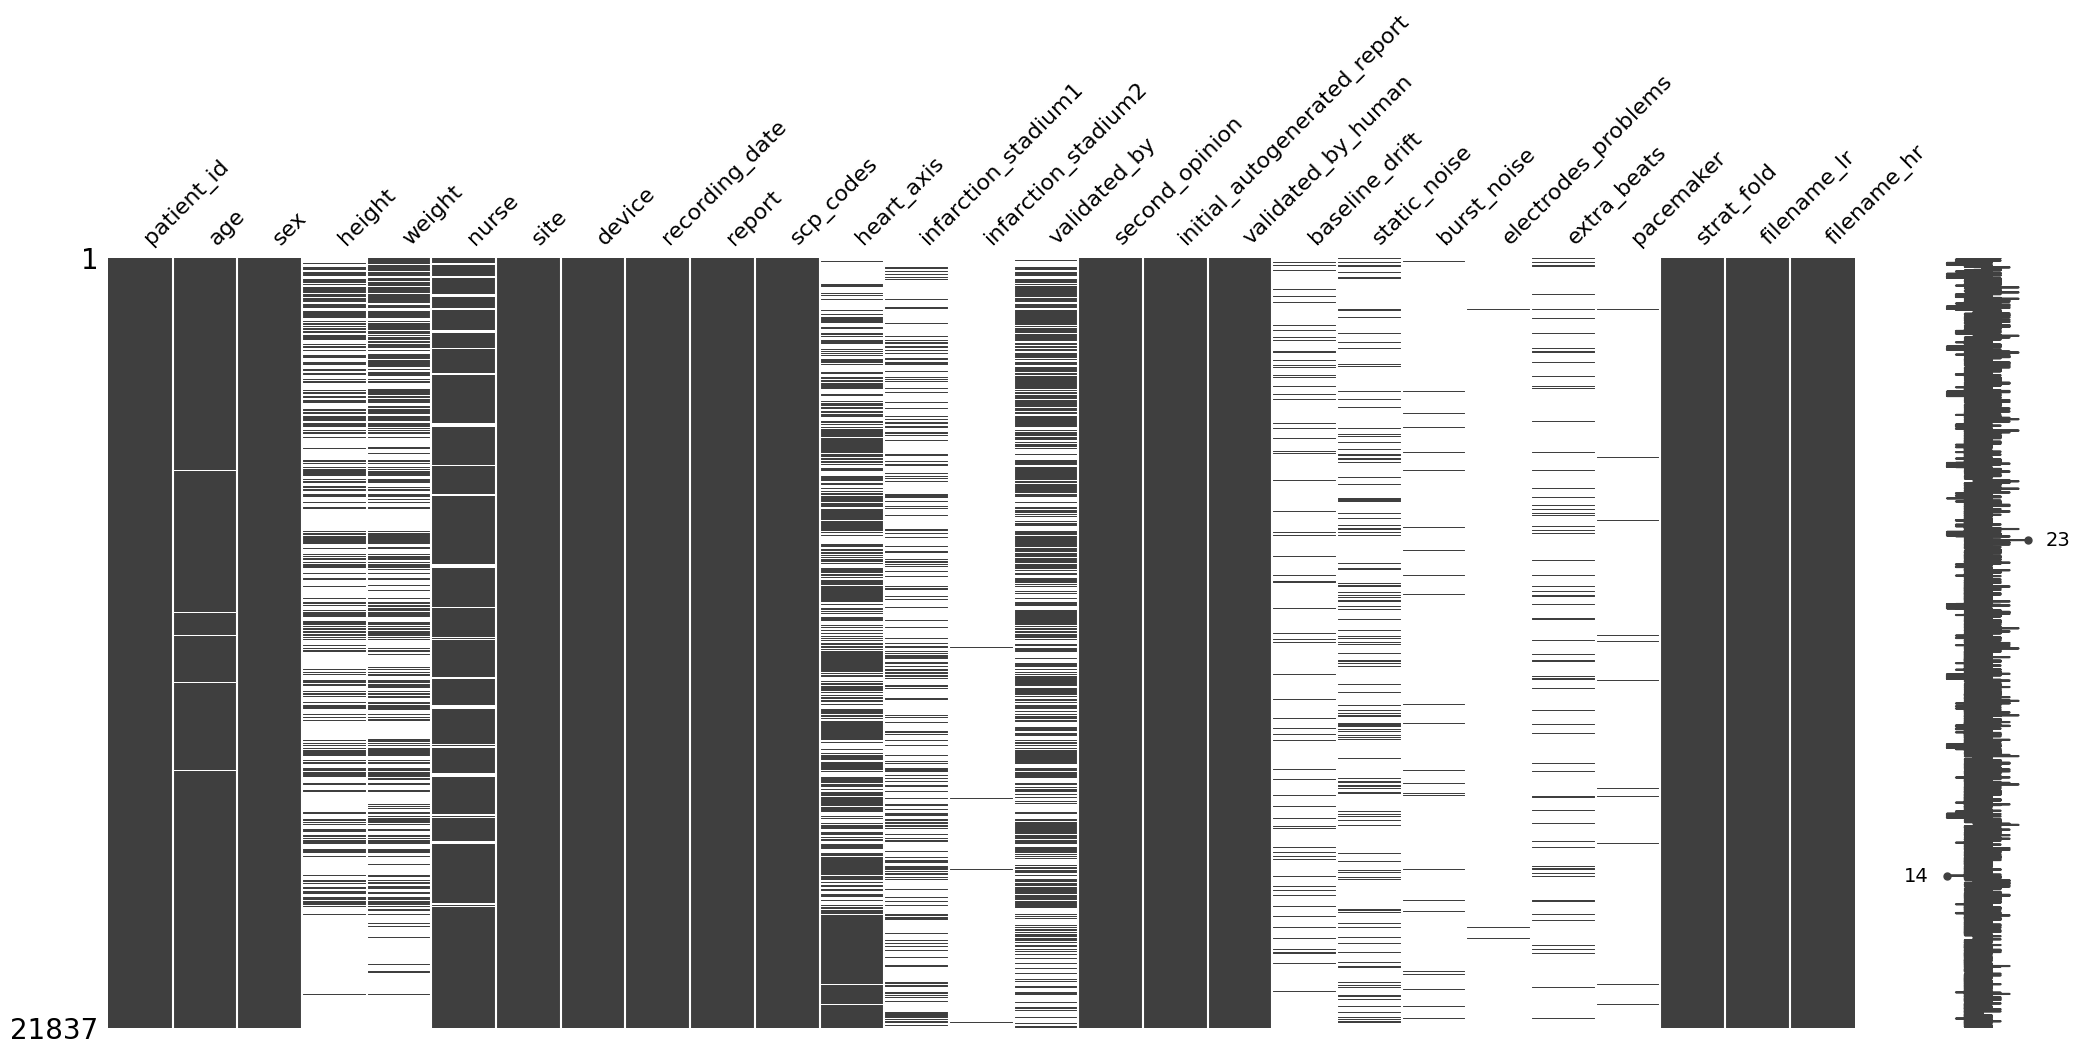

In [68]:
import missingno as msno

print(ECG_df.isnull().sum())


msno.matrix(ECG_df)
plt.show()

In [69]:
ECG_df[[col for col in ECG_df.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

patient_id                      18885
age                                94
sex                                 2
height                             77
weight                            127
nurse                              12
site                               51
device                             11
recording_date                  21813
report                           9883
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    321
static_noise                      124
burst_noise                       103
electrodes_problems                14
extra_beats                       128
pacemaker                           4
strat_fold                         10
filename_lr                     21837
filename_hr                     21837
dtype: int64

In [65]:
#Data Load for the ecg signals

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate = 100

ECG_data = load_raw_data(ECG_df, sampling_rate, PATH_TO_DATA)

ECG_data

array([[[-1.190e-01, -5.500e-02,  6.400e-02, ..., -2.600e-02,
         -3.900e-02, -7.900e-02],
        [-1.160e-01, -5.100e-02,  6.500e-02, ..., -3.100e-02,
         -3.400e-02, -7.400e-02],
        [-1.200e-01, -4.400e-02,  7.600e-02, ..., -2.800e-02,
         -2.900e-02, -6.900e-02],
        ...,
        [ 6.900e-02,  0.000e+00, -6.900e-02, ...,  2.400e-02,
         -4.100e-02, -5.800e-02],
        [ 8.600e-02,  4.000e-03, -8.100e-02, ...,  2.420e-01,
         -4.600e-02, -9.800e-02],
        [ 2.200e-02, -3.100e-02, -5.400e-02, ...,  1.430e-01,
         -3.500e-02, -1.200e-01]],

       [[ 4.000e-03,  1.380e-01,  1.340e-01, ...,  1.920e-01,
          8.300e-02,  8.800e-02],
        [-2.000e-02,  1.160e-01,  1.360e-01, ...,  1.560e-01,
          5.700e-02,  6.300e-02],
        [-5.300e-02,  9.200e-02,  1.450e-01, ...,  1.070e-01,
          1.300e-02,  2.200e-02],
        ...,
        [ 1.210e-01,  3.980e-01,  2.770e-01, ..., -1.065e+00,
         -4.920e-01, -1.560e-01],
        [-3.

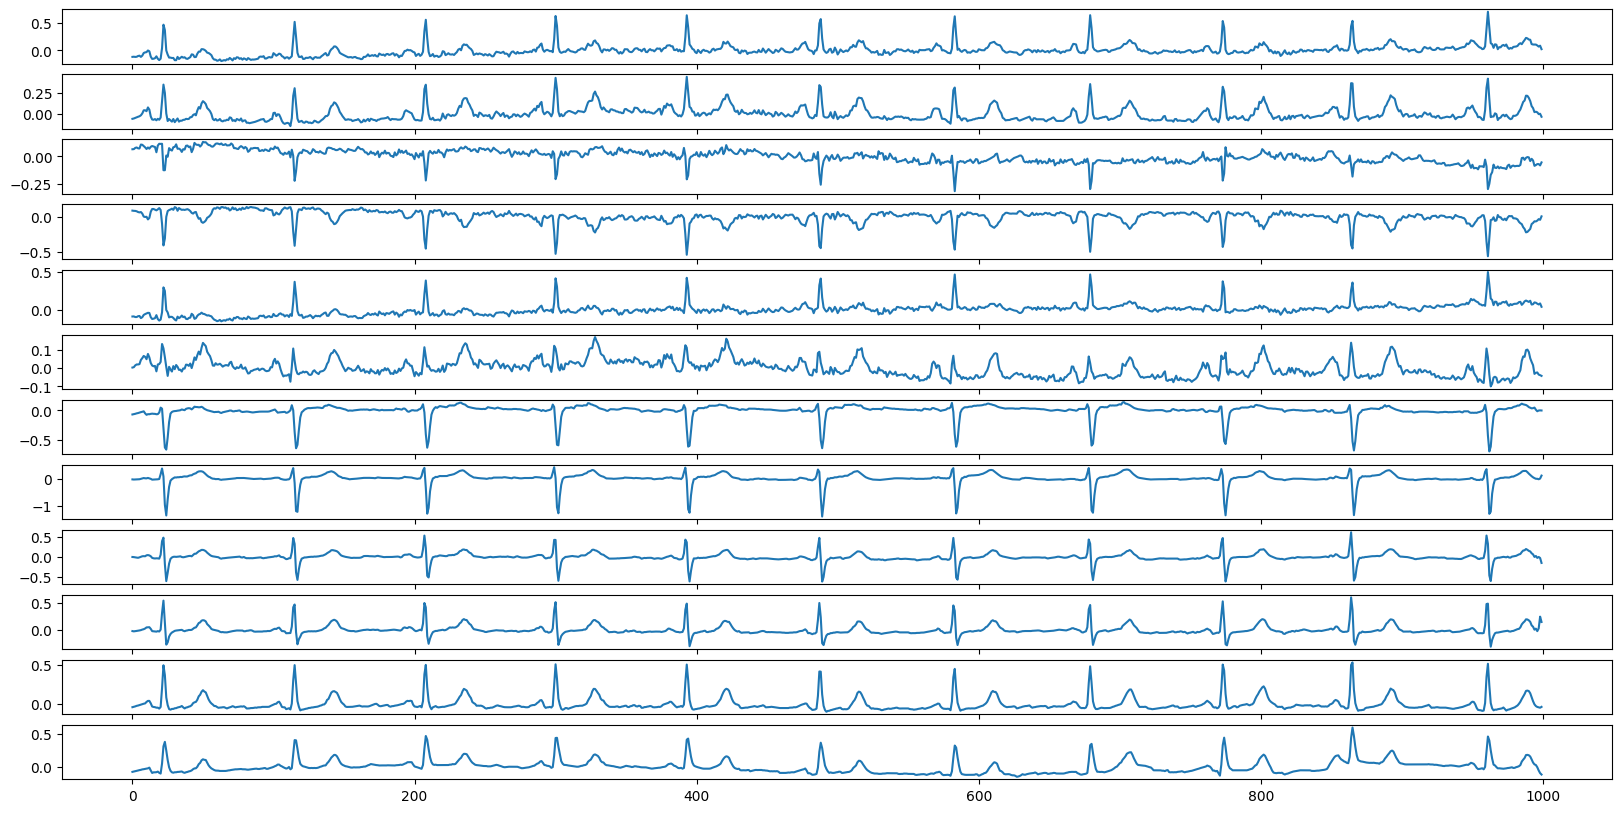

In [67]:
import warnings
warnings.filterwarnings('ignore')


sample = ECG_data[0]
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(20,10))
for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
# plt.tight_layout()
plt.show()

In [76]:
#Data Load for the targets

all_labels = sorted(SCP.index)

Z = np.zeros((len(ECG_df), len(all_labels)), dtype=int)

for i, (idx, row) in enumerate(ECG_df.iterrows()):
    for label in row.scp_codes.keys():
        if label in all_labels:
            Z[i, all_labels.index(label)] = 1
Z_df = pd.DataFrame(Z, index=ECG_df.index, columns=all_labels)
Z_df



,1AVB,2AVB,3AVB,ALMI,AMI,ANEUR,ASMI,CLBBB,CRBBB,DIG,...,LPFB,LVH,NDT,NORM,NST_,PMI,RAO/RAE,RVH,SEHYP,WPW
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
21834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
21835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
#Debugging for multilabel targets


label_counts = Z.sum(axis=1)


multi_label_indices = np.where(label_counts > 1)[0]


print(f"Number of samples with >1 label: {len(multi_label_indices)}")




Number of samples with >1 label: 6411


In [70]:
#Preparation

X = pd.DataFrame(index=ECG_df.index)

X['age'] = ECG_df.age
X.age.fillna(0, inplace=True)

X['sex'] = ECG_df.sex.astype(float)
X.sex.fillna(0, inplace=True)


#I've decided to keep the median because of the data science class I took I have no idea if it will work
valid_heights = ECG_df['height'].where((ECG_df['height'] >= 50))
median_height = valid_heights.median()
ECG_df['height'] = ECG_df['height'].apply(lambda x: median_height if pd.isna(x) or x < 50 else x)


X['weight'] = ECG_df.weight
X.weight.fillna(0, inplace=True)

X['infarction_stadium1'] = ECG_df.infarction_stadium1.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

X['infarction_stadium2'] = ECG_df.infarction_stadium2.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

X['pacemaker'] = (ECG_df.pacemaker == 'ja, pacemaker').astype(float)

X['extra_beats'] = ECG_df.extra_beats.replace({
    'SVES': 0.5,
    'VES': 1.0,
    'SVES+VES': 1.5,  
}).fillna(0.0).apply(lambda x: x if isinstance(x, float) else 0.0)

X



,age,sex,weight,infarction_stadium1,infarction_stadium2,pacemaker,extra_beats
ecg_id,,,,,,,
1,56.0,1.0,63.0,0.0,0.0,0.0,0.0
2,19.0,0.0,70.0,0.0,0.0,0.0,0.0
3,37.0,1.0,69.0,0.0,0.0,0.0,0.0
4,24.0,0.0,82.0,0.0,0.0,0.0,0.0
5,19.0,1.0,70.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
21833,67.0,1.0,0.0,0.0,0.0,0.0,0.0
21834,93.0,0.0,0.0,4.0,0.0,0.0,0.0
21835,59.0,1.0,0.0,0.0,0.0,0.0,0.0


In [71]:

# Ensure the ECG_data is aligned
assert X.shape[0] == ECG_data.shape[0] == Z.shape[0] == ECG_df.shape[0]

#Split it as .80, .10, ,10 
train_mask = ECG_df.strat_fold <= 8
valid_mask = ECG_df.strat_fold == 9
test_mask  = ECG_df.strat_fold == 10


X_train, Y_train, Z_train = X[train_mask],  ECG_data[train_mask.to_numpy()],  Z[train_mask.to_numpy()]
X_valid, Y_valid, Z_valid = X[valid_mask],  ECG_data[valid_mask.to_numpy()],  Z[valid_mask.to_numpy()]
X_test,  Y_test,  Z_test  = X[test_mask],   ECG_data[test_mask.to_numpy()],   Z[test_mask.to_numpy()]


print("Train:", X_train.shape, Y_train.shape, Z_train.shape)
print("Valid:", X_valid.shape, Y_valid.shape, Z_valid.shape)
print("Test: ", X_test.shape,  Y_test.shape,  Z_test.shape)


Train: (17441, 7) (17441, 1000, 12) (17441, 44)
Valid: (2193, 7) (2193, 1000, 12) (2193, 44)
Test:  (2203, 7) (2203, 1000, 12) (2203, 44)


In [72]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaler.fit(X_train)

X_train = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(X_scaler.transform(X_valid), columns=X_valid.columns)
X_test  = pd.DataFrame(X_scaler.transform(X_test),  columns=X_test.columns)

In [77]:
#per-lead stats
mean_per_lead = Y_train.mean(axis=(0, 2))  # shape (12,)
std_per_lead = Y_train.std(axis=(0, 2))    # shape (12,)

# Normalize function
def normalize_ecg(data, mean, std):
    return (data - mean[:, None]) / std[:, None]

# Step 3: Apply to each sample
Y_train = np.array([normalize_ecg(x, mean_per_lead, std_per_lead) for x in Y_train])
Y_valid = np.array([normalize_ecg(x, mean_per_lead, std_per_lead) for x in Y_valid])
Y_test  = np.array([normalize_ecg(x, mean_per_lead, std_per_lead) for x in Y_test])


In [81]:
#For quick loading later

NUMPY_DATA_FILE = '/kaggle/working/data.npz'

save_args = {
    'X_train': X_train.to_numpy().astype('float32'),
    'X_valid': X_valid.to_numpy().astype('float32'),
    'X_test':  X_test.to_numpy().astype('float32'),

    'Y_train': Y_train.astype('float32'),
    'Y_valid': Y_valid.astype('float32'),
    'Y_test':  Y_test.astype('float32'),

    'Z_train': Z_train.astype('float32'),  
    'Z_valid': Z_valid.astype('float32'),
    'Z_test':  Z_test.astype('float32'),
}

np.savez(NUMPY_DATA_FILE, **save_args)
print(f"Saved data to {NUMPY_DATA_FILE}")


Saved data to /kaggle/working/data.npz


In [16]:
from IPython.display import FileLink 

FileLink('/kaggle/input/testing/data.npz')

/kaggle/input/testing/data.npz

In [2]:
#I just keep this since I need to install it every time.
!pip install -q wfdb

import os
import ast
import wfdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

data = np.load('/kaggle/input/testing/data.npz')

X_train = data['X_train']
X_valid = data['X_valid']
X_test  = data['X_test']

Y_train = data['Y_train']
Y_valid = data['Y_valid']
Y_test  = data['Y_test']

Z_train = data['Z_train']
Z_valid = data['Z_valid']
Z_test  = data['Z_test']



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
class ECG1DCNN(nn.Module):
    def __init__(self, num_features, num_labels):
        super(ECG1DCNN, self).__init__()
        
        # CNN for ECG signal (12 leads)
        self.conv1 = nn.Conv1d(12, 32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.AdaptiveAvgPool1d(1)  # Output shape: (batch, 128, 1)

        # MLP for tabular features
        self.tabular_net = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 + 32, 64),
            nn.ReLU(),
            nn.Linear(64, num_labels),
            nn.Sigmoid()  # for multilabel
        )

    def forward(self, ecg, tabular):
        # ECG branch
        x = F.relu(self.bn1(self.conv1(ecg)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)  # flatten

        # Tabular branch
        t = self.tabular_net(tabular)

        # Concatenate & classify
        combined = torch.cat((x, t), dim=1)
        out = self.classifier(combined)
        return out


In [4]:
def train_model_selection(model, loaders, optimizer, criterion, epochs=10, dev=torch.device('cpu'), checkpoint_path='best_model.pt'):
    model = model.to(dev)
    best_val_loss = float('inf')
    history_loss = {'train': [], 'val': []}
    history_acc = {'train': [], 'val': []}

    for epoch in range(epochs):
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, corrects, total = 0.0, 0, 0

            for ecg, tabular, labels in loaders[phase]:
                ecg, tabular, labels = ecg.to(dev), tabular.to(dev), labels.to(dev)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(ecg, tabular)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * ecg.size(0)
                preds = (outputs > 0.5).float()
                corrects += (preds == labels).sum().item()
                total += labels.numel()

            epoch_loss = running_loss / len(loaders[phase].dataset)
            epoch_acc = corrects / total
            history_loss[phase].append(epoch_loss)
            history_acc[phase].append(epoch_acc)

            print(f"[{epoch+1}/{epochs}] {phase.upper()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

    return history_loss, history_acc



Training on device: cpu
Saving best model checkpoint to: ./ecg_best_model.pt
ECG1DCNN(
  (conv1): Conv1d(12, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): AdaptiveAvgPool1d(output_size=1)
  (tabular_net): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_

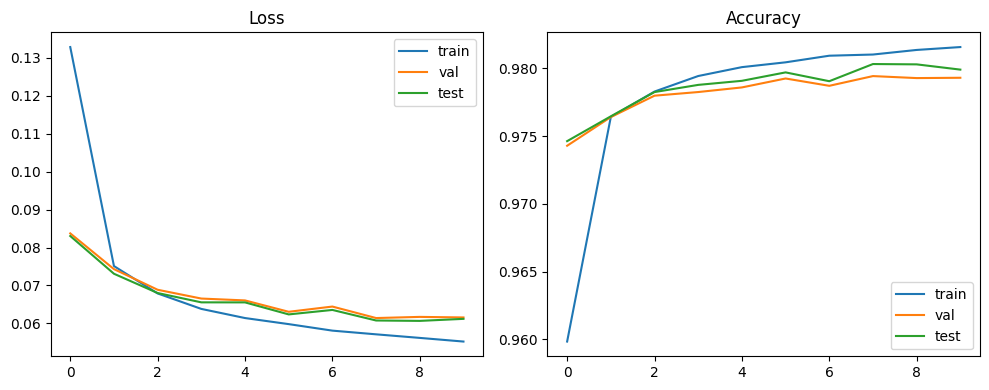

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np  # Make sure this is imported

# Define your model
num_features = X_train.shape[1]       # Tabular feature count
num_labels = Z_train.shape[1]         # Number of output labels (multilabel)
model = ECG1DCNN(num_features=num_features, num_labels=num_labels)

# Loss and optimizer
criterion = nn.BCELoss()  # For multilabel classification with sigmoid
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper to convert np arrays or pandas DataFrames to torch tensors
def to_tensor(x):
    return torch.tensor(x if isinstance(x, np.ndarray) else x.values, dtype=torch.float32)

train_dataset = TensorDataset(to_tensor(Y_train), to_tensor(X_train), to_tensor(Z_train))
val_dataset   = TensorDataset(to_tensor(Y_valid), to_tensor(X_valid), to_tensor(Z_valid))
test_dataset  = TensorDataset(to_tensor(Y_test),  to_tensor(X_test),  to_tensor(Z_test))

# Dataloaders
loaders = {
    "train": DataLoader(train_dataset, batch_size=64, shuffle=True),
    "val":   DataLoader(val_dataset, batch_size=64),
    "test":  DataLoader(test_dataset, batch_size=64)
}

def train_model_selection(model, loaders, optimizer, criterion, epochs=10, dev=torch.device('cpu'), checkpoint_path='./ecg_best_model.pt'):
    best_val_loss = float('inf')
    print(f"Training on device: {dev}")
    print(f"Saving best model checkpoint to: {checkpoint_path}")
    try:
        model = model.to(dev)
        print(model)

        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}

        for epoch in range(epochs):
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}

            for split in ["train", "val", "test"]:
                if not loaders.get(split):
                    print(f"Skipping {split} phase for epoch {epoch+1} due to empty loader.")
                    history_loss[split].append(float('nan'))
                    history_accuracy[split].append(float('nan'))
                    continue

                model.train() if split == "train" else model.eval()

                for ecg, tabular, labels in loaders[split]:
                    ecg = ecg.permute(0, 2, 1).to(dev) 
                    tabular = tabular.to(dev)
                    labels = labels.to(dev)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled(split == "train"):
                        outputs = model(ecg, tabular)
                        loss = criterion(outputs, labels)
                        if split == "train":
                            loss.backward()
                            optimizer.step()

                    sum_loss[split] += loss.item()
                    preds = (outputs > 0.5).float()
                    batch_acc = (preds == labels).sum().item() / labels.numel()
                    sum_accuracy[split] += batch_acc

            # Average epoch metrics
            epoch_loss = {s: (sum_loss[s] / len(loaders[s]) if loaders.get(s) else float('nan')) for s in ["train", "val", "test"]}
            epoch_acc = {s: (sum_accuracy[s] / len(loaders[s]) if loaders.get(s) else float('nan')) for s in ["train", "val", "test"]}

            # Save best model
            if loaders.get("val") and epoch_loss["val"] < best_val_loss:
                best_val_loss = epoch_loss["val"]
                torch.save({
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_loss": epoch_loss["val"]
                }, checkpoint_path)
                print(f"Epoch {epoch+1}: ✅ Saved best model with Val_Loss: {best_val_loss:.4f}")

            # Store history
            for s in ["train", "val", "test"]:
                history_loss[s].append(epoch_loss[s])
                history_accuracy[s].append(epoch_acc[s])

            # Print epoch summary
            print(f"Epoch {epoch+1}/{epochs}:",
                  f"Train Loss={epoch_loss['train']:.4f}," if loaders.get('train') else "TrL=N/A,",
                  f"Train Accuracy={epoch_acc['train']:.4f}," if loaders.get('train') else "TrA=N/A,",
                  f"Val Loss={epoch_loss['val']:.4f}," if loaders.get('val') else "VL=N/A,",
                  f"Val Accuracy={epoch_acc['val']:.4f}," if loaders.get('val') else "VA=N/A,",
                  f"Test Loss={epoch_loss['test']:.4f}," if loaders.get('test') else "TeL=N/A,",
                  f"Test Accuracy={epoch_acc['test']:.4f}" if loaders.get('test') else "TeA=N/A")

    except KeyboardInterrupt:
        print("Training interrupted manually.")

    finally:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            if loaders.get(split): plt.plot(history_loss[split], label=split)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            if loaders.get(split): plt.plot(history_accuracy[split], label=split)
        plt.legend()

        plt.tight_layout()
        plt.show()


train_model_selection(
    model,
    loaders=loaders,
    optimizer=optimizer,
    criterion=criterion,
    epochs=10,
    dev=device,
    checkpoint_path="./ecg_best_model.pt"
)


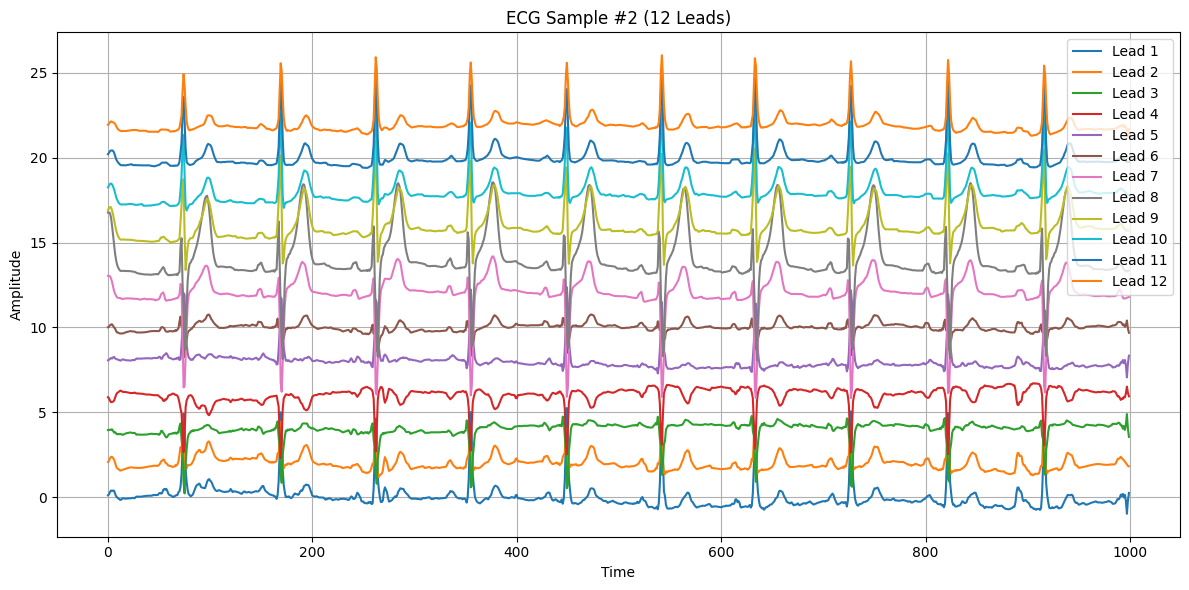

 True Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0]

 Predicted Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0]


In [8]:
import torch
import matplotlib.pyplot as plt


sample_idx = 2 


checkpoint = torch.load("./ecg_best_model.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()


ecg_sample, tabular_sample, true_labels = test_dataset[sample_idx]

ecg_input = ecg_sample.unsqueeze(0).permute(0, 2, 1).to(device)  # (1, 12, 1000)
tabular_input = tabular_sample.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(ecg_input, tabular_input)

pred_labels = (output > 0.5).float().cpu().squeeze()


plt.figure(figsize=(12, 6))
for i in range(12):
    plt.plot(ecg_sample[:, i] + i*2, label=f"Lead {i+1}")  # offset by +2 for clarity
plt.title(f"ECG Sample #{sample_idx} (12 Leads)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


print(" True Labels:")
print(true_labels.numpy().astype(int))

print("\n Predicted Labels:")
print(pred_labels.numpy().astype(int))
